# HW2 of DAML
- Dataset: store sale prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
# Load datasets
dataset = pd.read_csv('./store_sale_prediction/dataset.csv')
holidays_events = pd.read_csv('./store_sale_prediction/holidays_events.csv')
oil = pd.read_csv('./store_sale_prediction/oil.csv')
stores = pd.read_csv('./store_sale_prediction/stores.csv')
transactions = pd.read_csv('./store_sale_prediction/transactions.csv')
validation = pd.read_csv('./store_sale_prediction/validations.csv')

# Display the first few rows of each dataset for verification
print(dataset.head())
print(holidays_events.head())
print(oil.head())
print(stores.head())
print(transactions.head())
print(validation.head())


   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
         date  dcoilwtico
0  2013-01-01         NaN
1  20

In [3]:
# Ensure 'date' columns are in datetime format
dataset['date'] = pd.to_datetime(dataset['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
oil['date'] = pd.to_datetime(oil['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
validation['date'] = pd.to_datetime(validation['date'])

In [4]:
# Fill missing oil prices by forward filling
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_32910/3640111858.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil['dcoilwtico'].fillna(method='ffill', inplace=True)


In [5]:
# Merge datasets with suffixes to avoid column name conflicts
dataset = pd.merge(dataset, oil, on='date', how='left', suffixes=('', '_oil'))
dataset = pd.merge(dataset, holidays_events, on='date', how='left', suffixes=('', '_holiday'))
dataset = pd.merge(dataset, stores, on='store_nbr', how='left', suffixes=('', '_store'))
dataset = pd.merge(dataset, transactions, on=['date', 'store_nbr'], how='left', suffixes=('', '_transaction'))

# Handle column conflicts by dropping or renaming columns
columns_to_drop = [
    'dcoilwtico_oil', 'type_holiday', 'locale_holiday', 'locale_name_holiday', 'description_holiday', 'transferred_holiday',
    'type_store', 'locale_store', 'locale_name_store', 'description_store', 'transferred_store',
    'type_transaction', 'locale_transaction', 'locale_name_transaction', 'description_transaction', 'transferred_transaction'
]
dataset.drop(columns=[col for col in columns_to_drop if col in dataset.columns], inplace=True)

In [7]:
print(len(list(dataset.columns)))
for col in dataset.columns:
    print(col, end=',')

16
id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,city,state,cluster,transactions,

In [ ]:
dataset.tail(10)

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,city,state,cluster,transactions
3054338,3000878,2017-08-15,9,MAGAZINES,11.000,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054339,3000879,2017-08-15,9,MEATS,449.228,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054340,3000880,2017-08-15,9,PERSONAL CARE,522.000,11,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054341,3000881,2017-08-15,9,PET SUPPLIES,6.000,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054342,3000882,2017-08-15,9,PLAYERS AND ELECTRONICS,6.000,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,47.57,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,6,2155.0


In [9]:
# Fill any remaining missing values
dataset.fillna(0, inplace=True)

In [10]:
# Feature engineering: add new features if needed
dataset['year'] = dataset['date'].dt.year
dataset['month'] = dataset['date'].dt.month
dataset['day'] = dataset['date'].dt.day
dataset['dayofweek'] = dataset['date'].dt.dayofweek

## Validation Dataset

In [11]:
# Apply the same transformation to the validation set
validation = pd.merge(validation, oil, on='date', how='left', suffixes=('', '_oil'))
validation = pd.merge(validation, holidays_events, on='date', how='left', suffixes=('', '_holiday'))
validation = pd.merge(validation, stores, on='store_nbr', how='left', suffixes=('', '_store'))
validation = pd.merge(validation, transactions, on=['date', 'store_nbr'], how='left', suffixes=('', '_transaction'))
validation.fillna(0, inplace=True)
validation['year'] = validation['date'].dt.year
validation['month'] = validation['date'].dt.month
validation['day'] = validation['date'].dt.day
validation['dayofweek'] = validation['date'].dt.dayofweek


In [15]:
print(len(list(dataset.columns)))
for col in dataset.columns:
    print(col, end=',')

20
id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,city,state,cluster,transactions,year,month,day,dayofweek,

In [14]:
print(len(list(validation.columns)))
for col in validation.columns:
    print(col, end=',')

20
id,date,store_nbr,family,onpromotion,dcoilwtico,type,locale,locale_name,description,transferred,city,state,type_store,cluster,transactions,year,month,day,dayofweek,

In [18]:
# Define features and target
features = ['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'transactions', 'year', 'month', 'day', 'dayofweek']
X = dataset[features]
y = dataset['sales']

# One-hot encoding for categorical variables
X = pd.get_dummies(X, columns=['family'])

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to verify
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(2443478, 41)
(610870, 41)
(2443478,)
(610870,)


## Training

In [19]:
# Train a Random Forest model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validate the model
from sklearn.metrics import mean_squared_error
y_pred = model.predict(X_val)
print('Validation RMSE:', mean_squared_error(y_val, y_pred, squared=False))

Validation RMSE: 188.73371895227075


- To check the RSME, use mean value to predict the validation set

In [23]:
import numpy as np

# Calculate the mean sales in the training set
baseline_sales = np.mean(y_train)

# Predict the validation set using the baseline sales
baseline_predictions = np.full_like(y_val, baseline_sales)

# Calculate the RMSE for the baseline model
baseline_rmse = mean_squared_error(y_val, baseline_predictions, squared=False)
print('Baseline RMSE:', baseline_rmse)


Baseline RMSE: 1093.747755347675


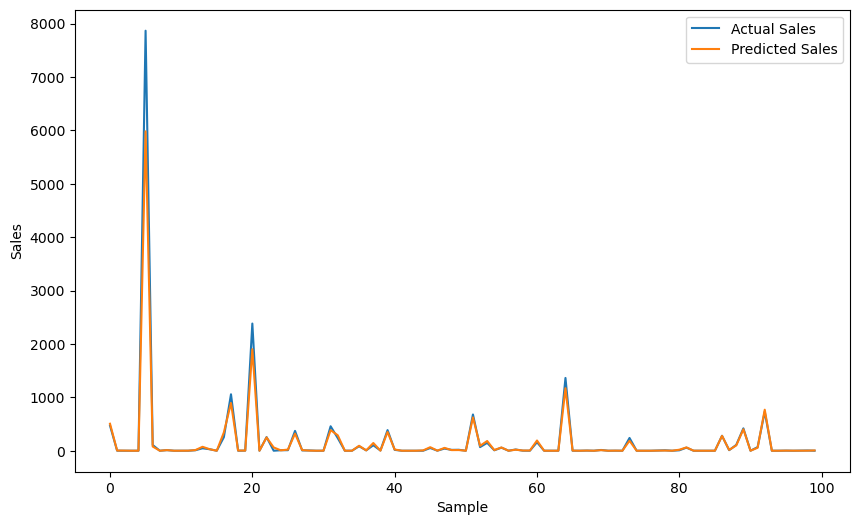

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_val.values[:100], label='Actual Sales')
plt.plot(y_pred[:100], label='Predicted Sales')
plt.xlabel('Sample')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [20]:
# Prepare validation features
X_test = validation[features]
X_test = pd.get_dummies(X_test, columns=['family'])

# Align the test set with the training set (in case of missing columns)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Predict sales for the validation set
validation['sales'] = model.predict(X_test)

# Save the results to a CSV file
output = validation[['id', 'sales']]
output.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
